In [1]:
# import data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
langs = pd.read_csv("langs.csv")
movies = pd.read_csv("movie_details.csv")
companies = pd.read_csv("companies.csv")
countries = pd.read_csv("countries.csv")
genres = pd.read_csv("genres.csv")

In [3]:
#Join/Merge datasets

movies = movies.rename(columns={"id": "movie_id"})
countries = countries.rename(columns={"country": "movie_country"})
companies = companies.rename(columns={"country": "company_country"})

# Merge directly on movie_id
merged = movies.merge(genres, on="movie_id", how="left")
merged = merged.merge(langs, on="movie_id", how="left")
merged = merged.merge(companies, on="movie_id", how="left")
merged = merged.merge(countries, on="movie_id", how="left")

print(merged.head())

   adult                     backdrop_path      belongs_to_collection  \
0  False  /9mJ9dxCGpudxyBtlC0M9Y4pTyXN.jpg  The Wild Robot Collection   
1  False  /9mJ9dxCGpudxyBtlC0M9Y4pTyXN.jpg  The Wild Robot Collection   
2  False  /9mJ9dxCGpudxyBtlC0M9Y4pTyXN.jpg  The Wild Robot Collection   
3  False  /9mJ9dxCGpudxyBtlC0M9Y4pTyXN.jpg  The Wild Robot Collection   
4  False  /au3o84ub27qTZiMiEc9UYzN74V3.jpg                      False   

     budget                           homepage  movie_id     imdb_id  \
0  78000000  https://www.thewildrobotmovie.com   1184918  tt29623480   
1  78000000  https://www.thewildrobotmovie.com   1184918  tt29623480   
2  78000000  https://www.thewildrobotmovie.com   1184918  tt29623480   
3  78000000  https://www.thewildrobotmovie.com   1184918  tt29623480   
4  18000000     https://www.elevationmovie.com   1035048  tt23558280   

  original_language  original_title  \
0                en  The Wild Robot   
1                en  The Wild Robot   
2          

In [4]:
#Explore the dataset

print("Shape:", merged.shape)
print("Columns:", merged.columns)
print(merged.info())
print(merged.describe())

Shape: (64876, 26)
Columns: Index(['adult', 'backdrop_path', 'belongs_to_collection', 'budget', 'homepage',
       'movie_id', 'imdb_id', 'original_language', 'original_title',
       'overview', 'popularity', 'poster_path', 'release_date', 'revenue',
       'runtime', 'status', 'tagline', 'title', 'video', 'vote_average',
       'vote_count', 'genre', 'lang', 'company_name', 'company_country',
       'movie_country'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64876 entries, 0 to 64875
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  64876 non-null  bool   
 1   backdrop_path          64701 non-null  object 
 2   belongs_to_collection  64876 non-null  object 
 3   budget                 64876 non-null  int64  
 4   homepage               35040 non-null  object 
 5   movie_id               64876 non-null  int64  
 6   imdb_id                64

In [5]:
# Drop irrelevant columns
to_drop = ["budget","backdrop_path", "poster_path", "homepage", "imdb_id",
           "overview", "tagline", "video", "belongs_to_collection",
           "original_title",'company_country','budget']
for col in to_drop:
    if col in merged.columns:
        merged = merged.drop(columns=col)

# dropna
merged = merged.dropna(subset=["genre",'lang','company_name',"revenue"])

# Remove rows where runtime <= 0
merged = merged[merged['runtime'] > 0]

# Fill missing numeric values with 0
for col in [ "revenue", "runtime", "popularity",
            "vote_average", "vote_count"]:
    if col in merged.columns:
        merged[col] = merged[col].fillna(0)

# Handle release_date
if "release_date" in merged.columns:
    merged["release_date"] = pd.to_datetime(merged["release_date"], errors="coerce")
    merged["release_year"] = merged["release_date"].dt.year.fillna(0).astype(int)
    merged = merged.drop(columns=["release_date"])

# Remove duplicates
merged = merged.drop_duplicates(subset=["movie_id"])

# save to file
merged.to_csv("cleaned_movie_data.csv", index=False)

print("After cleaning:", merged.shape)

After cleaning: (2846, 15)


In [6]:
print(merged.isna().sum())
print((merged['revenue'] <= 0).sum())
print((merged['runtime'] <= 0).sum())

adult                0
movie_id             0
original_language    0
popularity           0
revenue              0
runtime              0
status               0
title                0
vote_average         0
vote_count           0
genre                0
lang                 0
company_name         0
movie_country        0
release_year         0
dtype: int64
751
0


In [7]:
# understand the data
merged.info()
print('#'*50)
print(merged.describe().round(1))
print('#'*50)
print(merged.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 2846 entries, 0 to 64874
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   adult              2846 non-null   bool   
 1   movie_id           2846 non-null   int64  
 2   original_language  2846 non-null   object 
 3   popularity         2846 non-null   float64
 4   revenue            2846 non-null   int64  
 5   runtime            2846 non-null   int64  
 6   status             2846 non-null   object 
 7   title              2846 non-null   object 
 8   vote_average       2846 non-null   float64
 9   vote_count         2846 non-null   int64  
 10  genre              2846 non-null   object 
 11  lang               2846 non-null   object 
 12  company_name       2846 non-null   object 
 13  movie_country      2846 non-null   object 
 14  release_year       2846 non-null   int64  
dtypes: bool(1), float64(2), int64(5), object(7)
memory usage: 336.3+ KB
########

In [8]:
# check: Data cleaning
merged.isnull().sum()
merged=merged.drop(merged[(merged['vote_average']<0)|(merged['vote_average']>10)].index)
merged=merged.drop(merged[merged['revenue']<0].index)
print(merged['revenue'].dtype)


int64


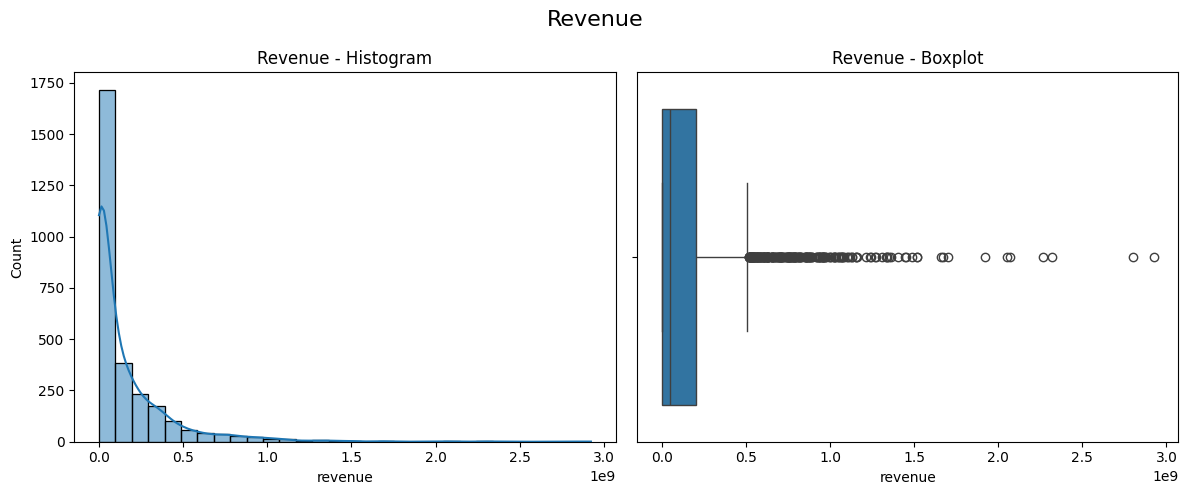

In [9]:
# univariate analysis
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(data=merged, x="revenue", bins=30, kde=True, ax=axes[0])
axes[0].set_title("Revenue - Histogram")
sns.boxplot(data=merged, x="revenue", ax=axes[1])
axes[1].set_title("Revenue - Boxplot")
fig.suptitle("Revenue", fontsize=16)

plt.tight_layout()
plt.show()


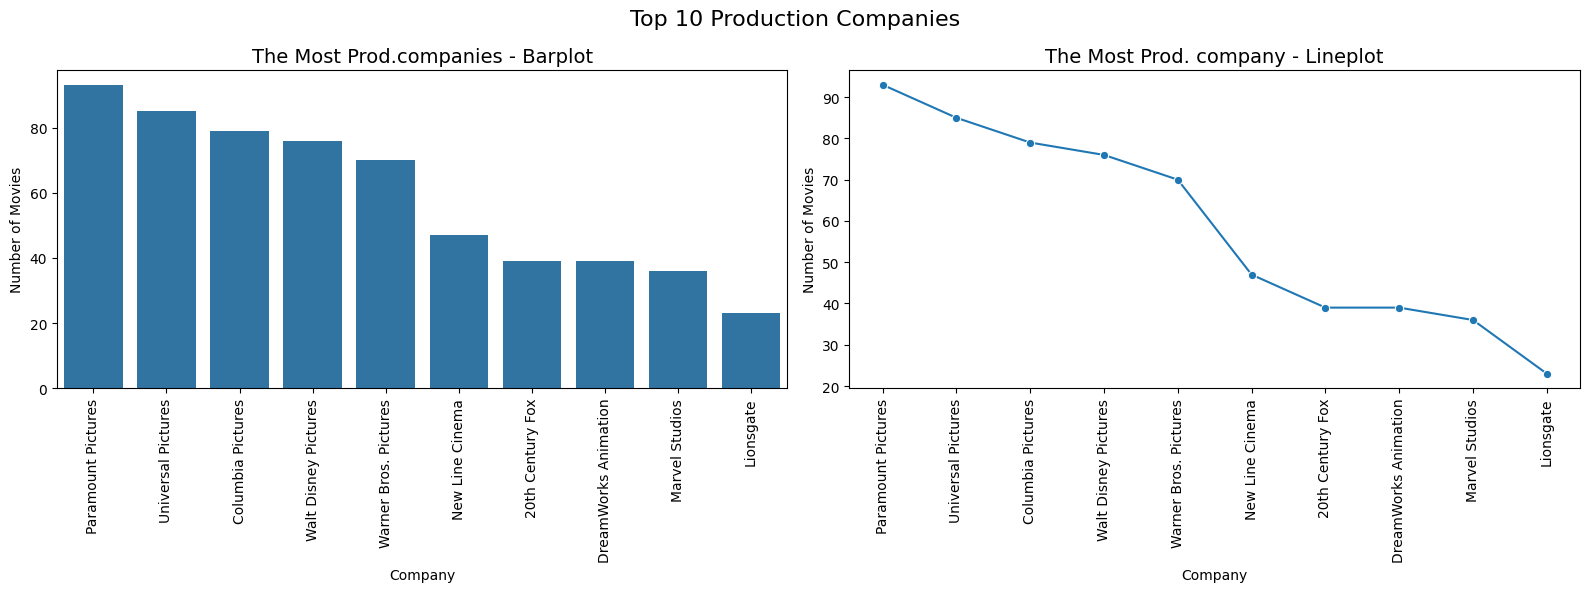

In [10]:
top10_companies = merged['company_name'].value_counts().head(10)
fig, axes = plt.subplots(1, 2, figsize=(16,6))
sns.barplot(x=top10_companies.index, y=top10_companies.values, ax=axes[0])
axes[0].set_title("The Most Prod.companies - Barplot", fontsize=14)
axes[0].set_xlabel("Company")
axes[0].set_ylabel("Number of Movies")
axes[0].tick_params(axis='x', rotation=90)


sns.lineplot(x=top10_companies.index, y=top10_companies.values, marker="o", ax=axes[1])
axes[1].set_title("The Most Prod. company - Lineplot", fontsize=14)
axes[1].set_xlabel("Company")
axes[1].set_ylabel("Number of Movies")
axes[1].tick_params(axis='x', rotation=90)

fig.suptitle("Top 10 Production Companies", fontsize=16)

plt.tight_layout()
plt.show()

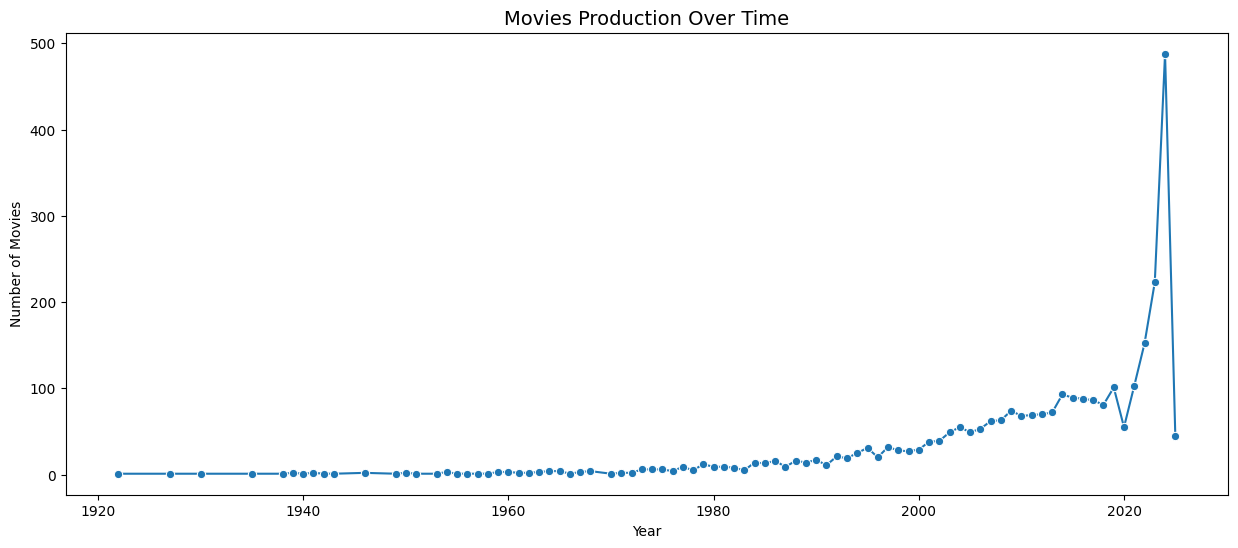

In [11]:
movies_per_year = merged['release_year'].value_counts().sort_index()

plt.figure(figsize=(15,6))
sns.lineplot(x=movies_per_year.index, y=movies_per_year.values, marker="o")
plt.title("Movies Production Over Time", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Number of Movies")
plt.show()

C:\Users\besho\AppData\Local\Temp\ipykernel_15424\1317626788.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


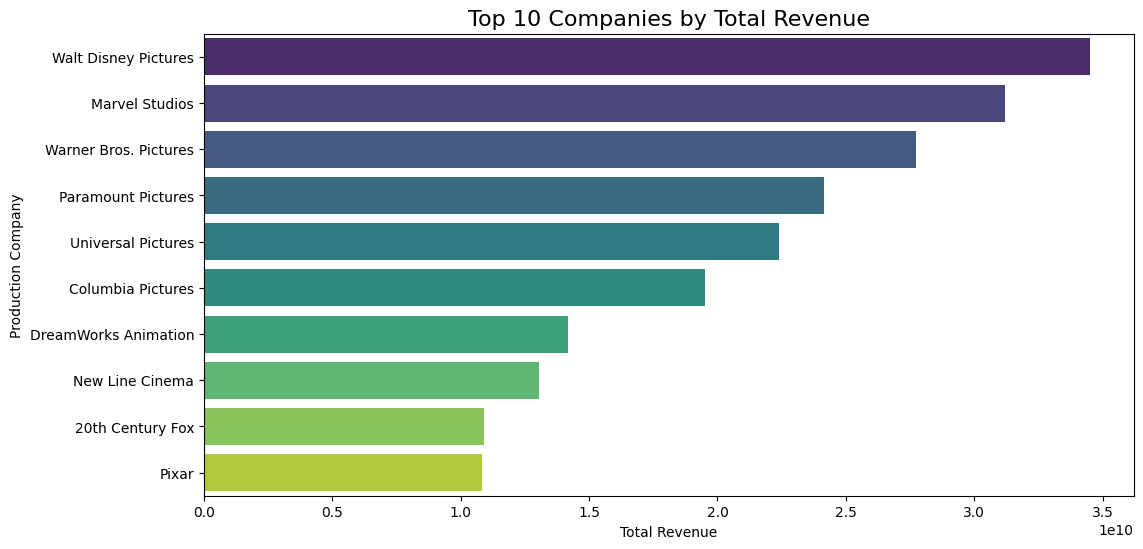

In [12]:
company_revenue = merged.groupby("company_name")["revenue"].sum()
top_10_companies = company_revenue.sort_values(ascending=False).head(10)
plt.figure(figsize=(12,6))
sns.barplot(
    x=top_10_companies.values,
    y=top_10_companies.index,
    palette="viridis"
)
plt.title("Top 10 Companies by Total Revenue", fontsize=16)
plt.xlabel("Total Revenue")
plt.ylabel("Production Company")
plt.show()

C:\Users\besho\AppData\Local\Temp\ipykernel_15424\929639721.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\besho\AppData\Local\Temp\ipykernel_15424\929639721.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


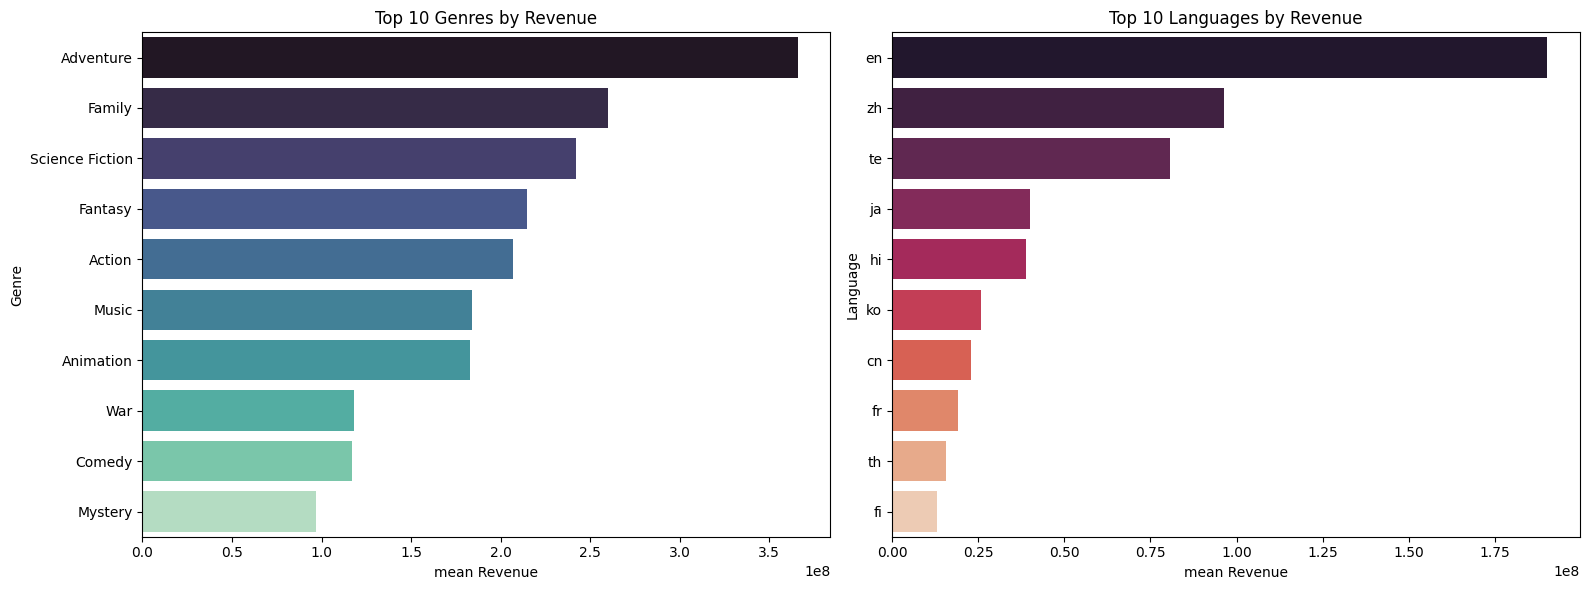

In [13]:
genre_revenue = merged.groupby("genre")["revenue"].mean().sort_values(ascending=False)
language_revenue = merged.groupby("original_language")["revenue"].mean().sort_values(ascending=False)
fig, axes = plt.subplots(1, 2, figsize=(16,6))
sns.barplot(
    x=genre_revenue.values[:10],   
    y=genre_revenue.index[:10],
    palette="mako",
    ax=axes[0]
)
axes[0].set_title("Top 10 Genres by Revenue")
axes[0].set_xlabel("mean Revenue")
axes[0].set_ylabel("Genre")

sns.barplot(
    x=language_revenue.values[:10],   
    y=language_revenue.index[:10],
    palette="rocket",
    ax=axes[1]
)
axes[1].set_title("Top 10 Languages by Revenue")
axes[1].set_xlabel("mean Revenue")
axes[1].set_ylabel("Language")

plt.tight_layout()
plt.show()

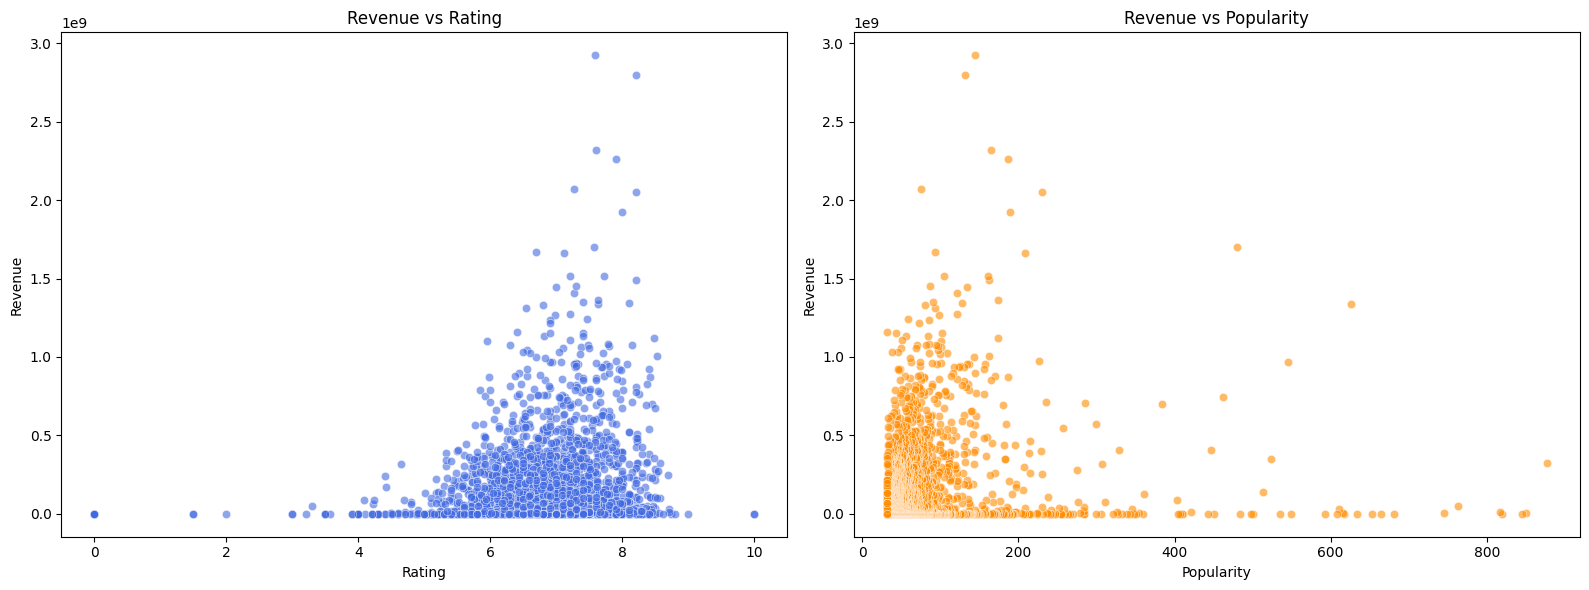

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
sns.scatterplot(
    data=merged,
    x="vote_average",  
    y="revenue",       
    alpha=0.6,         
    color="royalblue",
    ax=axes[0]
)
axes[0].set_title("Revenue vs Rating")
axes[0].set_xlabel("Rating")
axes[0].set_ylabel("Revenue")

sns.scatterplot(
    data=merged,
    x="popularity",  
    y="revenue",
    alpha=0.6,
    color="darkorange",
    ax=axes[1]
)
axes[1].set_title("Revenue vs Popularity")
axes[1].set_xlabel("Popularity")
axes[1].set_ylabel("Revenue")

plt.tight_layout()
plt.show()

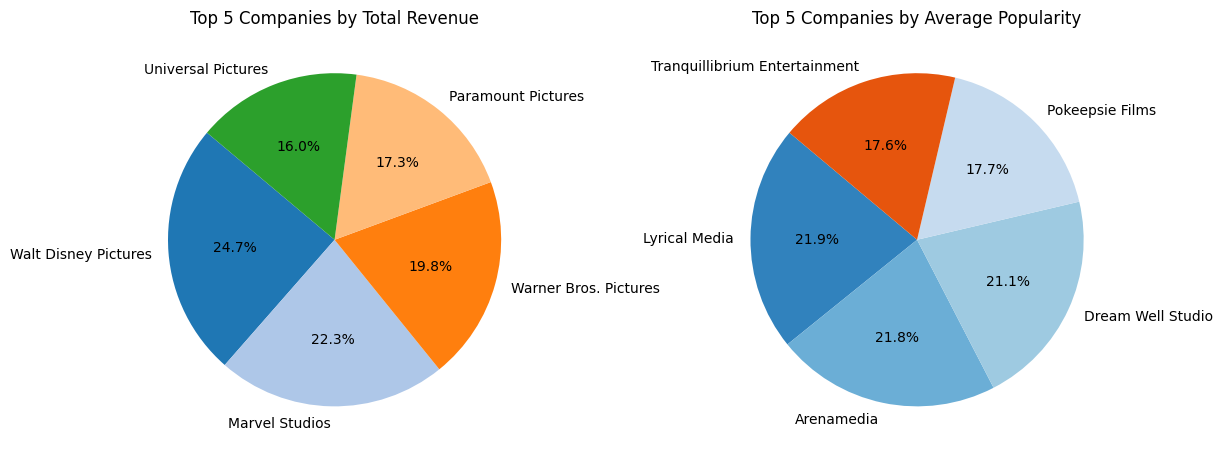

In [15]:
company_revenue = merged.groupby("company_name")["revenue"].sum().sort_values(ascending=False)

company_popularity = merged.groupby("company_name")["popularity"].mean().sort_values(ascending=False)

top5_revenue = company_revenue.head(5)
top5_popularity = company_popularity.head(5)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.pie(
    top5_revenue.values,
    labels=top5_revenue.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.tab20.colors
)
plt.title("Top 5 Companies by Total Revenue")
plt.subplot(1,2,2)
plt.pie(
    top5_popularity.values,
    labels=top5_popularity.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.tab20c.colors
)
plt.title("Top 5 Companies by Average Popularity")

plt.tight_layout()
plt.show()

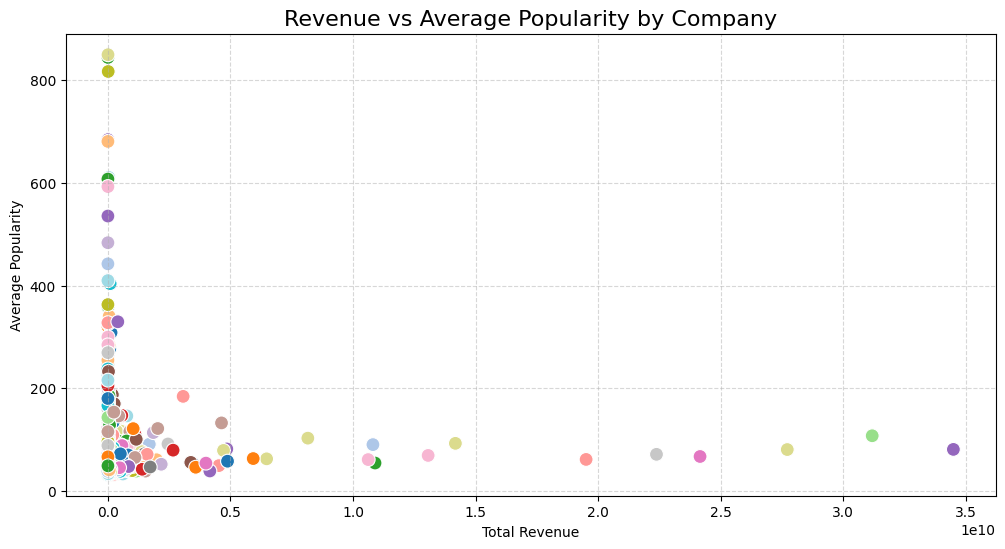

In [16]:

company_stats = merged.groupby("company_name").agg({
    "revenue": "sum",
    "popularity": "mean"
}).reset_index()

plt.figure(figsize=(12,6))
sns.scatterplot(
    data=company_stats,
    x="revenue",
    y="popularity",
    hue="company_name",
    palette="tab20",
    s=100,
    legend=False 
)
plt.title("Revenue vs Average Popularity by Company", fontsize=16)
plt.xlabel("Total Revenue")
plt.ylabel("Average Popularity")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [17]:
#Build Machine Learning models

# Features and target
X = merged.drop(columns=["movie_id", "title", "revenue"], errors="ignore")
y = merged["revenue"]

# Keep only numeric columns
X = X.select_dtypes(include=[np.number])

print(X.columns)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Index(['popularity', 'runtime', 'vote_average', 'vote_count', 'release_year'], dtype='object')


In [18]:
# Model 1: Decision Tree Regressor
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
pred_dt = dt.predict(X_test)
print("Decision Tree R2:", r2_score(y_test, pred_dt))
print("Decision Tree MSE:", mean_squared_error(y_test, pred_dt))

Decision Tree R2: 0.4521890876963026
Decision Tree MSE: 5.025521951025556e+16


In [19]:
# Model 2: Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)
print("Linear Regression R2:", r2_score(y_test, pred_lr))
print("Linear Regression MSE:", mean_squared_error(y_test, pred_lr))

Linear Regression R2: 0.5719797663277126
Linear Regression MSE: 3.9265831174437704e+16


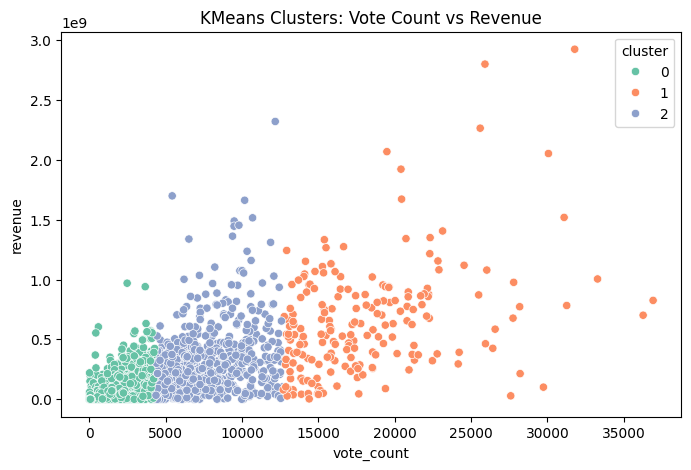

In [20]:
# Model 3: KMeans (Clustering on features)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X)

merged["cluster"] = clusters

# Plot clusters (Vote Count vs Revenue)
plt.figure(figsize=(8, 5))
sns.scatterplot(x="vote_count", y="revenue", hue="cluster", data=merged, palette="Set2")
plt.title("KMeans Clusters: Vote Count vs Revenue")
plt.show()

In [21]:
#Conclusion
print("\n--- Conclusion ---")
print("We built 3 models to analyze movie revenue:")
print("- The Decision Tree model fit the training data but may overfit.")
print("- Linear Regression gave a baseline performance for predicting revenue.")
print("- KMeans helped group movies into clusters based on budget and revenue.")
print("In general, budget has a clear impact on revenue, but other factors also play a role.")


--- Conclusion ---
We built 3 models to analyze movie revenue:
- The Decision Tree model fit the training data but may overfit.
- Linear Regression gave a baseline performance for predicting revenue.
- KMeans helped group movies into clusters based on budget and revenue.
In general, budget has a clear impact on revenue, but other factors also play a role.
